# Abstract


In this AI project, we propose a deep learning model that predicts the exact target location through the Time Difference Of Arrival for each location measurement sensor in an environment where there are indoor obstacles and errors. The deep learning model we envisioned proceeds in the following order. Errors that may occur due to internal obstacles are reflected in the TDOA measurement value for each sensor. TDOA data with errors reflected is converted into TDOA images. A TDOA image consists of the probabilities of a hyperbola graph passing through each image grid. Train a CNN model with fully connected layers to estimate target positions via backpropagation by accumulating and processing TDOA images as input data. We compared the performance of a model using CNN and a simple learning model and examined where our results can be applied in real life.



# Introduction 


With the development of IT technology, unmanned systems are gradually being used in many fields. In particular, in unmanned stores for example Amazon Go, when a customer puts items in a shopping cart and goes straight to the exit without a checkout process, the product that are purchased are identified and payment is automatically made. This technology is possible because many sensors and cameras in the store can determine what products a customer has in their shopping cart.

However, these sensors and cameras are expensive to purchase and for operate. In order to reduce cost, Recent preliminary studies have tried to obtain accurate TDOA through several algorithms, especially deep learning.

Several studies that use deep-learning, TDOA for location , method simply inferred the correct TDOA value and tracked the location using the hyperbolic equation, and did not use deep learning for the entire process. In addition, the method of estimating the position through TDOA is essential to find the intersection of the hyperbolic equations, but this process needs a lot of computer resources to solve these complex nonlinear equations. 

Therefore, to solve these problems, we will build a deep lear:ning model that estimates the exact coordinates of the target by using the TDOA values extracted from the rough space. In particular, we will build a CNN model by converting each TDOA measurement into a TDOA image. We expect that it will be possible to accurately and quickly determine the location of the target even in complex spaces such as unmanned convenience stores and indoor gyms.


<img src='https://drive.google.com/uc?id=1TMMkuAUOBCZzD8MhjaiZyF6aXK7ZXfKB' width="400"> 
<img src='https://drive.google.com/uc?id=1TMdM__fzPziQVLQ3xDkhUgrxpKAwxh3z' width="400">

<Fig1. Amazon Go camera and sensors> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<Fig2. Estimate target coordinate by TDOA>



# Simulation architecture
1. Generate true target coordinate - ($y$)
2. Generate target coordinate from device - ($\hat{y}$)
3. Generate TOA data and apply noise and Frasnel zone distance and calculate TDOA
4. Convert TDOA data into TDOA image
5. Make CNN model
6. Create Output 

<img src='https://drive.google.com/uc?id=1iSyJAdws-qDoLC8H5hq-zk-Gy60onsg0' width="1200">


# Our codes

## Implement packages

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plot
import math
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

## Hyperparameters 


In [2]:
NOISE = 2
MEAN_NOISE = 0.1

######################################################
# fix me
# Parameters for CNNs
CNN1_inputchannel = 3
CNN1_outchannel = 32 
CNN1_kernal = 11
CNN1_stride = 1

CNN2_outchannel = 64
CNN2_kernal = 8
CNN2_stride = 1

CNN3_outchannel = 128
CNN3_kernal = 4
CNN3_stride = 1

Pool_kernal = 2 # max pooling
Pool_stride = 2

num_epochs = 50
batch_size = 15

sensor_ref = [0,0]
sensor1 = [10,0]
sensor2 = [0,10]
sensor3 = [10,10]

world_size_x = 10
world_size_y = 10
grid_size = 0.1

epsilon = 0.02
probability_gap = 20
######################################################

MC_N = 10** 4  # Number of total simulation
MC_N = int(MC_N * 1.6)

size_x = 10   # X axis size
size_y = 10   # Y axis size

# Overall procsees for creating train dataset

1. Create arbitraely X and Y target data between 0~25
    + Target data is made!
2. Apply random noise to arbitraely generated target data (hat data)
    + this is hat data that measured by device
    + X target data with noise is X_hat, Y target data with noise is Y_hat
3. Create distance between each sensor and hat data

4. Apply environmental error

5. Create TDOA between reference sensor and each sensor

6. Change TDOA to TDOA image


### Create arbitraely X and Y target data between 0~25


<img src='https://drive.google.com/uc?id=1TMCu_GfO0clZAngFK1pWDkqDCh19s_KH' width="400">


+ Sensor_ref = [0,0]
+ Sensor_1 = [25,0]
+ Sensor_2 = [0,25]
+ Sensor_3 = [25,25]

+ Target = [x,y] (0 <= x,y <= 25)



In [3]:
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops


class DiffGrad(optimizer_v2.OptimizerV2):
    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-7,
                 name='DiffGrad',
                 **kwargs):
        super(DiffGrad, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self.epsilon = epsilon or backend_config.epsilon()

    def _create_slots(self, var_list):
        # Create slots for the first and second moments.
        # Separate for-loops to respect the ordering of slot variables from v1.
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        for var in var_list:
            self.add_slot(var, 'prev_g')

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(DiffGrad, self)._prepare_local(var_device, var_dtype, apply_state)

        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)
        lr = (apply_state[(var_device, var_dtype)]['lr_t'] *
              (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
        apply_state[(var_device, var_dtype)].update(dict(
            lr=lr,
            epsilon=ops.convert_to_tensor(self.epsilon, var_dtype),
            beta_1_t=beta_1_t,
            beta_1_power=beta_1_power,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            beta_2_power=beta_2_power,
            one_minus_beta_2_t=1 - beta_2_t
        ))

    def set_weights(self, weights):
        params = self.weights
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(DiffGrad, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'] + m_scaled_g_values,
                               use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'] + v_scaled_g_values,
                               use_locking=self._use_locking)

        # diffgrad
        prev_g = self.get_slot(var, 'prev_g')
        dfc = 1.0 / (1.0 + math_ops.exp(-math_ops.abs(prev_g - grad)))

        v_sqrt = math_ops.sqrt(v_t)
        var_update = state_ops.assign_sub(
            var, coefficients['lr'] * m_t * dfc / (v_sqrt + coefficients['epsilon']),
            use_locking=self._use_locking)

        new_prev_g = state_ops.assign(prev_g, grad, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t, new_prev_g])

    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
        raise RuntimeError('This optimizer does not support sparse gradients.')

    def get_config(self):
        config = super(DiffGrad, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'decay': self._serialize_hyperparameter('decay'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'epsilon': self.epsilon,
        })
        return config

In [4]:
def target_moving(x_cor_list, y_cor_list, velocity_list, acceleration_list): #측정 시간 단위는 1초로! 속도 단위는 m/s
    x_cor_t_n_1 = x_cor_list[-1]
    y_cor_t_n_1 = y_cor_list[-1]
    velocity = velocity_list[-1]
    acceleration = acceleration_list[-1]
    
    s = velocity * 1        
    direction = 360 * np.random.rand(1)
    
    x_cor_t_n = x_cor_t_n_1 + s * math.cos(direction)
    y_cor_t_n = y_cor_t_n_1 + s * math.sin(direction)
    
    if(x_cor_t_n > world_size_x or x_cor_t_n < 0):
        x_cor_t_n = x_cor_t_n - 2 * s * math.cos(direction)
        
    if(y_cor_t_n > world_size_y or y_cor_t_n < 0):
        y_cor_t_n = y_cor_t_n - 2 * s * math.sin(direction)
        
    
    x_cor_list.append(round(x_cor_t_n,2))
    y_cor_list.append(round(y_cor_t_n,2))   
    
    acceleration = 0.5 * float(np.random.randn(1))
    velocity = velocity + acceleration * 1
    
    if(velocity < 0):
        velocity = 0
        
    elif(velocity>5): #인간 평균 걸음 속도는 1.1m/s 이고 뛰는 평균 속도는 5m/s이다
        velocity = 1.1
    
    acceleration_list.append(round(acceleration,2))
    velocity_list.append(round(velocity,2))
    
# 타겟 X(대문자 X) , x좌표 x(소문자 x)    
X_x_list = [world_size_x / 2]    # 타겟의 첫 x좌표
X_y_list = [world_size_y / 2]    # 타겟의 첫 y좌표 
velocity_list = [1.1]
acceleration_list =[0]   


while(len(X_x_list) < MC_N):
    target_moving(X_x_list, X_y_list, velocity_list, acceleration_list)


sensor_ref_x_list = [0] * MC_N                      #sensor ref x coordinate
sensor_ref_y_list = [0] * MC_N                      #sensor ref  y coordinate
sensor_one_x_list = [size_x] * MC_N                 #sensor 1 x coordinate
sensor_one_y_list = [0] * MC_N                      #sensor 1 y coordinate
sensor_two_x_list = [0] * MC_N                      #sensor 2 x coordinate
sensor_two_y_list = [size_y] * MC_N                 #sensor 2 y coordinate
sensor_three_x_list = [size_x] * MC_N                #sensor 3 x coordinate
sensor_three_y_list = [size_y] * MC_N                #sensor 3 y coordinate

df = pd.DataFrame(data = {'X_x':X_x_list , 'X_y' : X_y_list  
                         })

c:\Users\user\.conda\envs\position31\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\user\.conda\envs\position31\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

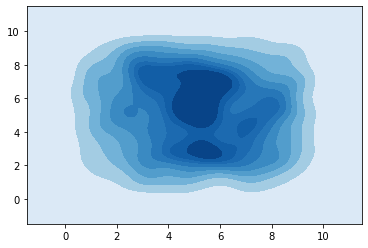

In [5]:
sns.kdeplot(X_x_list , X_y_list, cmap = "Blues" , shade= True, shade_lowest=True)

c:\Users\user\.conda\envs\position31\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


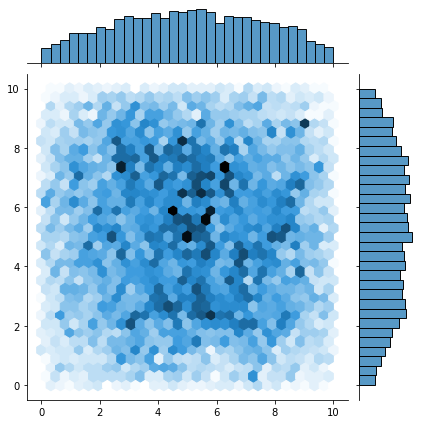

In [6]:
sns.jointplot(X_x_list, X_y_list, kind="hex")

### Example of a TDOA dataset created through an actual experiment.

<img src='https://drive.google.com/uc?id=1Wym8DdqfQuY4VSDFmxiogRXUl_ade25X' width="600">

### Create distance between each sensor and hat data

In [7]:
from __future__ import division, print_function
from multilateration_tdoa import TDoAEngine, TDoAMeasurement, Anchor, Point
import numpy as np

def noise():
    """Returns gaussian noise"""
    return np.random.normal(MEAN_NOISE, NOISE)

def tdoa(A,B,P):
    """Computes |PB| - |PA| + gaussian noise"""
    return P.dist(B)-P.dist(A) + noise()

def fakeTDOA(A,B,P):
    """Returns a fake measurements with anchors A, B from a point P"""
    return TDoAMeasurement(A, B, tdoa(A,B,P))

engine = TDoAEngine(n_measurements=6, max_dist_hess=100) # Avoid value rejection.

A = Anchor((0,0,0))
B = Anchor((world_size_x,0,0))
C = Anchor((world_size_x,world_size_y,0))
D = Anchor((0,world_size_y,0))

TDOA_X_hat_ref_one_error_list = [-100] * MC_N  
TDOA_X_hat_ref_two_error_list = [-100] * MC_N  
TDOA_X_hat_ref_three_error_list = [-100] * MC_N  
 

for i in range(MC_N):
    P = Point(X_x_list[i],X_y_list[i],0)
    
    TDOA_X_hat_ref_one_error_list[i] =   float(fakeTDOA(A, B, P).tdoa) # ref과 앵커 B와 TDOA
    TDOA_X_hat_ref_two_error_list[i] =  float(fakeTDOA(A, C, P).tdoa) # ref과 앵커 C와 TDOA
    TDOA_X_hat_ref_three_error_list[i] =   float(fakeTDOA(A, D, P).tdoa)# ref과 앵커 D와 TDOA

df['TDOA_X_hat_ref_one_error'] = TDOA_X_hat_ref_one_error_list
df['TDOA_X_hat_ref_two_error'] = TDOA_X_hat_ref_two_error_list
df['TDOA_X_hat_ref_three_error'] = TDOA_X_hat_ref_three_error_list

df_parsing = df[['TDOA_X_hat_ref_one_error' , 'TDOA_X_hat_ref_two_error' , 'TDOA_X_hat_ref_three_error' , 'X_x' , 'X_y']]
df_parsing.columns = ['TDOA_1', 'TDOA_2', 'TDOA_3' , 'coordinate_x' , 'coordinate_y']

df_parsing = df_parsing.reset_index(drop=True)

TDOA_X_ref_one_list = df_parsing['TDOA_1'].tolist()
TDOA_X_ref_two_list = df_parsing['TDOA_2'].tolist()
TDOA_X_ref_three_list = df_parsing['TDOA_3'].tolist()

TDOA_pair_ref = [(TDOA_X_ref_one_list[ii], TDOA_X_ref_two_list[ii], TDOA_X_ref_three_list[ii]) for ii in range(len(TDOA_X_ref_one_list))]

ylabel_ref = [(X_x_list[ii] / size_x, X_y_list[ii] / size_y ) for ii in range(len(X_x_list))] 

### Scaling for data 

In [8]:
def ScalerCoordinate(value):   #world size = area's width and height , value =  x,y coordinate
    world_size = 10
    value = value / world_size
    return value


def ScalerTDOA(value):   #world size = area's width and height , value = TDOA value
    #world_size = 25 * 2**(0.5)
    world_size = 100  
    value = value / world_size
    return value


df = df_parsing

df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']] = df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].apply(ScalerTDOA)  #길이에 대하여 스케일링
df[['coordinate_x' , 'coordinate_y']] = df[['coordinate_x' , 'coordinate_y']].apply(ScalerCoordinate)  #좌표에 대하여 스케일링

train_df , test_df = train_test_split(df, test_size = 0.2)

train_TDOAs = train_df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].to_numpy()
train_X_Hats = train_df[['coordinate_x' , 'coordinate_y']].to_numpy()

test_TDOAs = test_df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].to_numpy()
test_X_Hats = test_df[['coordinate_x' , 'coordinate_y']].to_numpy()

### Create TDOA Image from TDOA data

+ Reason why we use image data
1. Hyperbola is a non-linear equation, and the calculation cost needs to be simplified, not a joke.
2. High position uncertainty due to time subtraction operation to make TDOA
3. In a very robust environment, the TDOA error value correction algorithm does not work well. To solve this, other methods are needed instead of correcting the values!




#### Initial Idea:
+ Make TDOA image by transform TDOA hyperbola into grid world.
+ Each grid contains value of 0 or 1. 
+ value 1 means TDOA hyperbola passes grid, and 0 is not.

\
<img src='https://drive.google.com/uc?id=1TME89PaXmGiGE7kCSiAGq4ohkLRBcJSe' width="1000">

#### Modificated idea:
An image of the 'probability' that the hyperbolic equation will pass through the grid area

+ Make TDOA image by transform TDOA hyperbola into grid world.
+ Each grid contains value between 0 and 1. 
+ Each value means probability that TDOA hyperbola passes grid.
+ If grid value is close to 1, it means there are high probability that hyperbola passes.

+ If the difference between the TDOA value calculated by the center coordinates of each grid world and the TDOA value of the actual target is very small, we can predict that the target is in the grid world.
+ We can gradually decrease the probability by increasing the value of this epsilon.



<img src='https://drive.google.com/uc?id=1Hb-TvYikfaonQrfYqtqO5sIEBuuUd--y' width="1000">



In [9]:
# TDOA image 생성 모듈 정의
# input: TDPA
# output: TDOA_images
  
def TDOA_image_generation(sensor1, sensor2, TDOA, world_size_x, world_size_y, grid_size, epsilon, probability_gap):
   
  center_x = np.linspace(0 , world_size_x , int(world_size_x / grid_size))  + 0.5*grid_size  # x길이 10에 그리드사이즈가 2로 가정했을때 해당 좌표의 중심 좌표는 1, 3, 5, 7, 9 => 이를 수학적으로 수열화 한거!
  center_y = np.linspace(world_size_y , 0 , int(world_size_x / grid_size))  + 0.5*grid_size  # 마찬가지
  cord_center_x, cord_center_y = np.meshgrid(center_x,center_y)  #이를 매트릭스화
  
  distance_matrix = np.sqrt((cord_center_x - sensor1[0])**2 + (cord_center_y - sensor1[1])**2) - np.sqrt((cord_center_x - sensor2[0])**2 + (cord_center_y - sensor2[1])**2)  # 그리드 사이즈 중심좌표로부터 센서간의 거리의 계산 차 (=중심 좌표의 TDOA)
  tdoa_distance = np.abs(distance_matrix - TDOA)  #실제 TDOA 값과 차이 계산

  # 예시 [[10.8,0.38]
  #        [7.679,12.6479]]

  tdoa_image =  tdoa_distance // epsilon  #앱실론의 몇배인지 계산하기 위해서 ex) 앱실론이 0.1 이고 거리차가 0.38이면 0이 되겠죠?
  tdoa_image[tdoa_image > probability_gap] = probability_gap  # 너무 차이나는 애들 통일 ex) 앱실론이 0.1이고 거리차가 15든 12이든 밑의 계산을 위해 10(probability)으로 통일
  
  tdoa_image = (probability_gap - tdoa_image) / probability_gap #( [[10,10]     -   [[10,0]]   ) / 10   =  [[0,1]
                                                                #   10,10]]         [7,10]                  [0.3,0]]

  return tdoa_image

  #### Image size

- Since Grid_size is 0.25, image size is 100,100

In [10]:
TDOA_sample = TDOA_pair_ref[0][0]
TDOA_sample_image = TDOA_image_generation(sensor_ref, sensor1, TDOA_sample, world_size_x, world_size_y, grid_size, epsilon, probability_gap)
TDOA_sample_image.shape

(100, 100)

In [11]:
'''
TDOA_images_ref = np.empty(shape=[1,3,TDOA_sample_image.shape[0],TDOA_sample_image.shape[1] ])
for ii in range(len(TDOA_pair_ref)):
    image1 = TDOA_image_generation(sensor_ref, sensor1, TDOA_pair_ref[ii][0], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    image2 = TDOA_image_generation(sensor_ref, sensor2, TDOA_pair_ref[ii][1], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    image3 = TDOA_image_generation(sensor_ref, sensor3, TDOA_pair_ref[ii][2], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    #TDOA_images_ref.append((image1, image2, image3))
    image_temp = np.stack((image1, image2, image3),axis=0)
    TDOA_images_ref = np.append(TDOA_images_ref, np.expand_dims(image_temp, axis=0),axis=0)
    if(len(TDOA_images_ref) % 1000 == 0):
      print(len(TDOA_images_ref))
      
TDOA_images_ref = TDOA_images_ref[1:]
TDOA_images_ref.shape
'''

'\nTDOA_images_ref = np.empty(shape=[1,3,TDOA_sample_image.shape[0],TDOA_sample_image.shape[1] ])\nfor ii in range(len(TDOA_pair_ref)):\n    image1 = TDOA_image_generation(sensor_ref, sensor1, TDOA_pair_ref[ii][0], world_size_x, world_size_y, grid_size, epsilon, probability_gap)\n    image2 = TDOA_image_generation(sensor_ref, sensor2, TDOA_pair_ref[ii][1], world_size_x, world_size_y, grid_size, epsilon, probability_gap)\n    image3 = TDOA_image_generation(sensor_ref, sensor3, TDOA_pair_ref[ii][2], world_size_x, world_size_y, grid_size, epsilon, probability_gap)\n    #TDOA_images_ref.append((image1, image2, image3))\n    image_temp = np.stack((image1, image2, image3),axis=0)\n    TDOA_images_ref = np.append(TDOA_images_ref, np.expand_dims(image_temp, axis=0),axis=0)\n    if(len(TDOA_images_ref) % 1000 == 0):\n      print(len(TDOA_images_ref))\n      \nTDOA_images_ref = TDOA_images_ref[1:]\nTDOA_images_ref.shape\n'

In [12]:
TDOA_images_ref = []
for ii in range(len(TDOA_pair_ref)):
    image1 = TDOA_image_generation(sensor_ref, sensor1, TDOA_pair_ref[ii][0], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    image2 = TDOA_image_generation(sensor_ref, sensor2, TDOA_pair_ref[ii][1], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    image3 = TDOA_image_generation(sensor_ref, sensor3, TDOA_pair_ref[ii][2], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    TDOA_images_ref.append((image1, image2, image3))
    if(len(TDOA_images_ref) % 1000 == 0):
      print(len(TDOA_images_ref))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


### Split train and test set

In [13]:
TDOA_images_cnn = TDOA_images_ref
ylabels = ylabel_ref

TDOA_images_test = TDOA_images_cnn[int(0.8*MC_N):]
TDOA_image_val = TDOA_images_cnn[int(0.6*MC_N):int(0.8*MC_N)]
TDOA_image_train = TDOA_images_cnn[:int(0.6*MC_N)]

ylabels_test = ylabels[int(0.8*MC_N):]
ylabels_val = ylabels[int(0.6*MC_N):int(0.8*MC_N)]
ylabels_train = ylabels[:int(0.6*MC_N)]

### Make model structure



In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.Sequential()

model.add(layers.Conv2D(CNN1_outchannel, (CNN1_kernal, CNN1_kernal), activation=layers.LeakyReLU(alpha=0.01), strides=CNN1_stride, 
                        input_shape= (TDOA_sample_image.shape[0],TDOA_sample_image.shape[1], CNN1_inputchannel) ,kernel_initializer='he_normal'))
model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides= (Pool_stride, Pool_stride), padding = "SAME"  ) )
model.add(layers.Conv2D(CNN2_outchannel, (CNN2_kernal, CNN2_kernal),  activation=layers.LeakyReLU(alpha=0.01), strides=CNN2_stride ,kernel_initializer='he_normal'))
model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides=  (Pool_stride, Pool_stride), padding = "SAME"))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal), activation=layers.LeakyReLU(alpha=0.01), strides=CNN3_stride ,kernel_initializer='he_normal'))
model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides=  (Pool_stride, Pool_stride), padding = "SAME"))
model.add(layers.Conv2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal), activation=layers.LeakyReLU(alpha=0.01), strides=CNN3_stride ,kernel_initializer='he_normal')) 
model.add(layers.BatchNormalization()) 
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation=None))

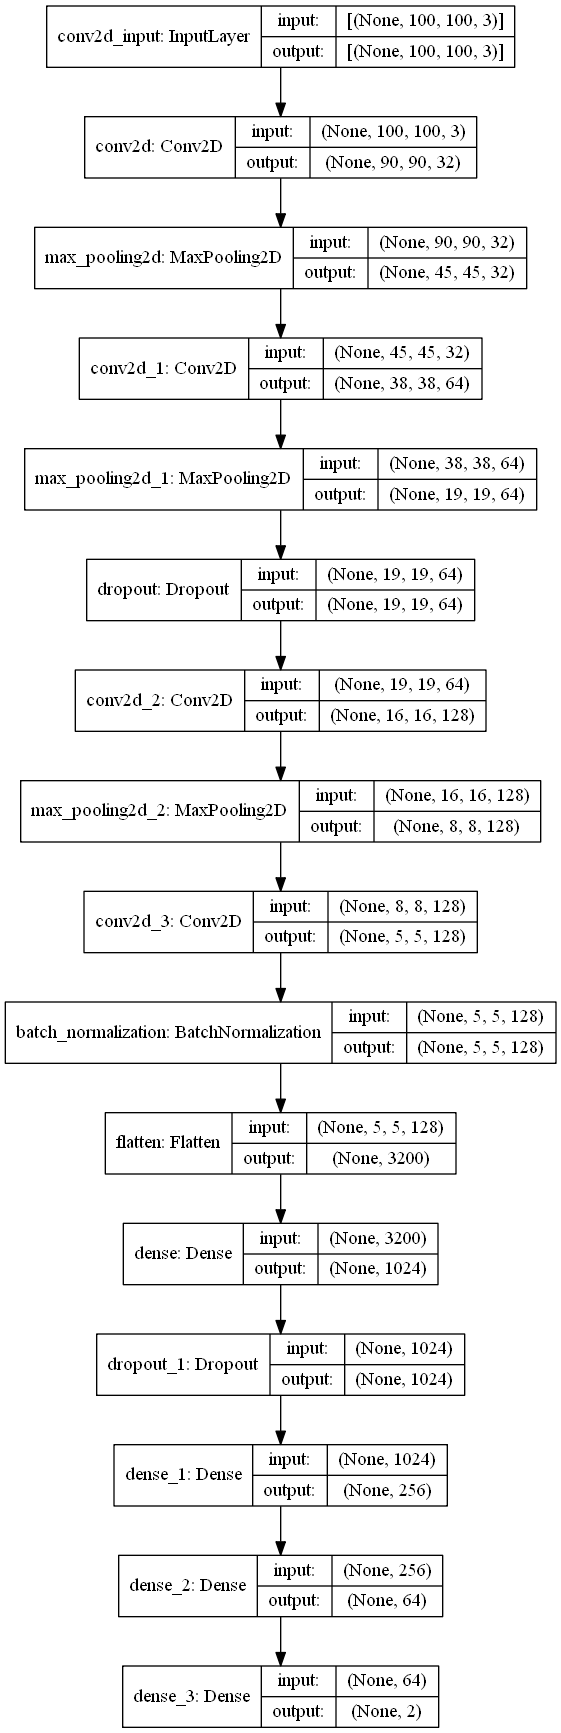

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [69]:
from tensorflow.keras.optimizers import Adam

save_loss = {}

model.summary()


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', 
                              patience=12) 

model.compile(optimizer=Adam(learning_rate=0.5 * 1e-3),
        loss='MSE',
        metrics=['mse'])


history = model.fit(np.array(TDOA_image_train).swapaxes(1,3), np.array(ylabels_train),
                    epochs=num_epochs, batch_size=batch_size,verbose=1,
                    validation_data=(np.array(TDOA_image_val).swapaxes(1,3), np.array(ylabels_val)),
                     callbacks= [ earlystopping])

print('Finished Training')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 90, 90, 32)        11648     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 38, 38, 64)        131136    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)        

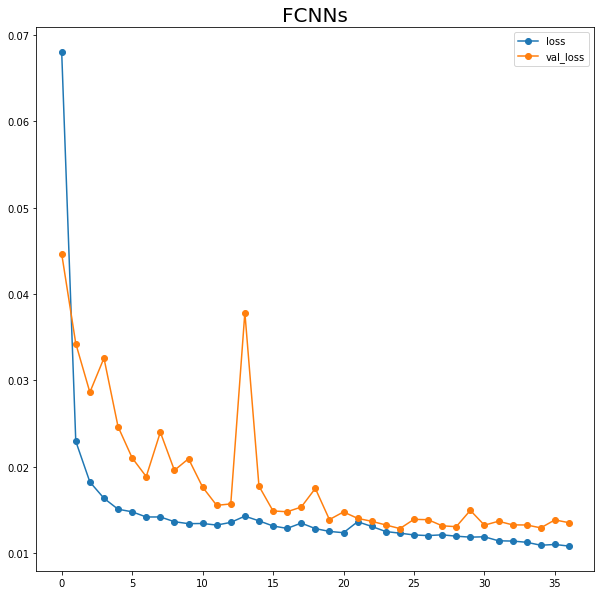

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

hist = history
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

ax.plot(hist.history["loss"], label = 'loss', marker='o')
ax.plot(hist.history["val_loss"], label = 'val_loss', marker='o')
ax.legend()

plt.title('CNN', fontsize=20)
plt.show()

In [71]:
predict_X_Hats = model.predict(np.array(TDOA_images_test).swapaxes(1,3))

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x - np.array(ylabels_test)*world_size_x), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  1.4416 미터


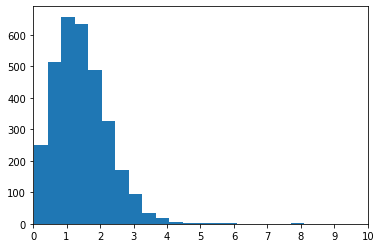

In [72]:
plt.hist(distance_gap, bins=20)
plt.xlim(0,10)
plt.xticks(range(0,11,1))
plt.show()


  <img src='https://drive.google.com/uc?id=1TRRt2YHofQiDwstmSEIkLiWsmK2EKut5' width="350">

# Results

### 1. Grid size really matters. 

The smaller the grid size, the more data for model input become more complex but the result is better. (Tradeoff between computational time and error)

< For grid_size = 1>

<img src='https://drive.google.com/uc?id=1TOz4y_V3nlOJZOyQVXCMRR7hfQhtSV-J' width="350">

< For grid_size = 0.5>

<img src='https://drive.google.com/uc?id=1TPEyYMEnw373MX247bg8uNxfVx038zNt' width="300">


### 2. Probability_gap and Epsilon must change relation to Grid size 

If the value grid size changes, the hyperparameters must be modified accordingly.In the process, the following facts were additionally discovered.



*   The probability gap is not unconditionally good because it is large unlike the grid size.
*   Most of the epsilon values showed good performance when values slightly smaller than (gridsize / probability_gap * 2).



### 3. Comparing with reference paper [Nitsoo et al., 2018]

<img src='https://drive.google.com/uc?id=1TPrf8VJXT4FzvFmAspuF8G5nIhLNfFix' width="600">


  <img src='https://drive.google.com/uc?id=1TQu6JWMw4gs6nN97aX13zp1oFusLRFN_' width="600">

  In our reference paper, coverage area is 13m x 20m, 
  \
   MAE is 0.3m~0.8m by various algorithms.

  Our coverage area is 25m x 25m and MAE for CNN model is 0.4m
  \
  If we consider large coverage area compare and error rate, our result is quite **meaningful** even considering that the environment is a little different.




## 3. FCNN (Fully connected Neural Network) Result

In [79]:
# Do not modify this block
from tensorflow.keras import models
from tensorflow.keras import layers

model2 = models.Sequential()
model2.add(layers.Dense(32, activation='relu', input_shape=(3,)))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(2))
model2.compile(optimizer='adam', loss='mse', metrics=['mse'])

num_epochs2 = 20

history = model2.fit(train_TDOAs[:int(0.75*MC_N)], 
                      train_X_Hats[:int(0.75*MC_N)],
                      epochs=num_epochs2,
                      batch_size=batch_size,
                      validation_data = (train_TDOAs[int(0.75*MC_N):], train_X_Hats[int(0.75*MC_N):]),
                      verbose=1)



Epoch 1/20
800/800 [==============================] - 2s 2ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 2/20
800/800 [==============================] - 2s 2ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 3/20
800/800 [==============================] - 2s 2ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 4/20
800/800 [==============================] - 2s 2ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5/20
800/800 [==============================] - 2s 2ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 6/20
800/800 [==============================] - 2s 2ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 7/20
800/800 [==============================] - 2s 2ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 8/20
800/800 [==============================] - 2s 2ms/step - loss: 0.

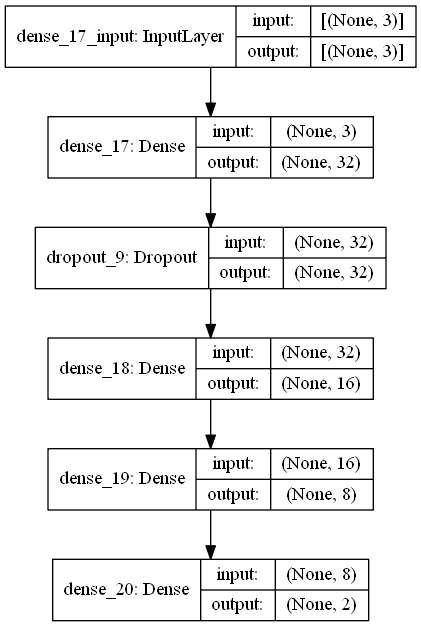

In [63]:
plot_model(model2, show_shapes=True, show_layer_names=True)

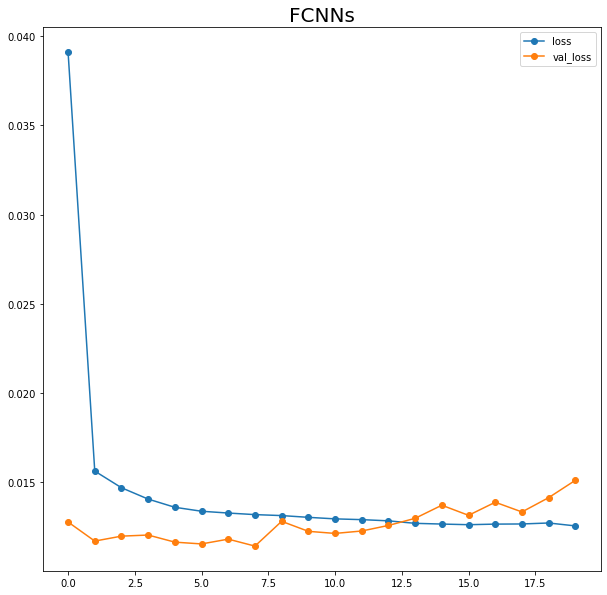

In [64]:
hist = history
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

ax.plot(hist.history["loss"], label = 'loss', marker='o')
ax.plot(hist.history["val_loss"], label = 'val_loss', marker='o')
ax.legend()

plt.title('FCNNs', fontsize=20)
plt.show()

In [65]:
predict_X_Hats = model2.predict(test_TDOAs)

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x - test_X_Hats*world_size_x), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  1.5722 미터


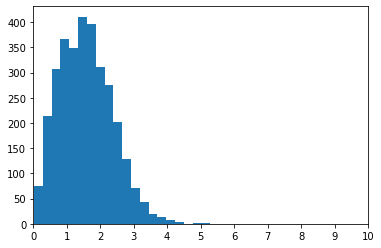

In [66]:
plt.hist(distance_gap, bins=20)
plt.xlim(0,10)
plt.xticks(range(0,11,1))
plt.show()

# Simple LSTM

In [73]:
def buildDataSet(X, y, seqLength):
    xdata = []
    ydata = [] 
    for i in range(0, len(X)-seqLength):
        tx = X[i:i+seqLength,:]
        ty = y[i+seqLength,[-1]]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

seqLength=4
trainX_lstm, trainY_lstm=buildDataSet(train_TDOAs, train_X_Hats, seqLength)
testX_lstm, testY_lstm=buildDataSet(test_TDOAs, test_X_Hats, seqLength)

In [83]:
from tensorflow.keras.layers import LSTM

model_lstm = models.Sequential()
model_lstm.add(LSTM(32,input_shape=(seqLength, 3),return_sequences=True)) 
model_lstm.add(layers.Dropout(0.5)) 
model_lstm.add(LSTM(16, return_sequences=True))
model_lstm.add(LSTM(8, return_sequences=False))
model_lstm.add(layers.Dropout(0.5)) 
model_lstm.add(layers.Dense(2)) 
model_lstm.compile(optimizer=Adam(learning_rate=1.0 * 1e-3), loss='mse', metrics=['mse'])


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', 
                              patience=10) 

history = model_lstm.fit(trainX_lstm[:int(0.75*MC_N)], 
                      trainY_lstm[:int(0.75*MC_N)],
                      epochs=30,
                      batch_size=batch_size,
                      verbose=1,
                      validation_data= (trainX_lstm[int(0.75*MC_N):], trainY_lstm[int(0.75*MC_N):]),
                      callbacks= [earlystopping] 
                      )
                      
                      

Epoch 1/30
800/800 [==============================] - 6s 5ms/step - loss: 0.0666 - mse: 0.0666 - val_loss: 0.0615 - val_mse: 0.0615
Epoch 2/30
800/800 [==============================] - 4s 5ms/step - loss: 0.0628 - mse: 0.0628 - val_loss: 0.0621 - val_mse: 0.0621
Epoch 3/30
800/800 [==============================] - 4s 5ms/step - loss: 0.0627 - mse: 0.0627 - val_loss: 0.0621 - val_mse: 0.0621
Epoch 4/30
800/800 [==============================] - 4s 5ms/step - loss: 0.0626 - mse: 0.0626 - val_loss: 0.0616 - val_mse: 0.0616
Epoch 5/30
800/800 [==============================] - 4s 5ms/step - loss: 0.0625 - mse: 0.0625 - val_loss: 0.0615 - val_mse: 0.0615
Epoch 6/30
800/800 [==============================] - 4s 5ms/step - loss: 0.0627 - mse: 0.0627 - val_loss: 0.0615 - val_mse: 0.0615
Epoch 7/30
800/800 [==============================] - 4s 5ms/step - loss: 0.0626 - mse: 0.0626 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 8/30
800/800 [==============================] - 4s 5ms/step - loss: 0.

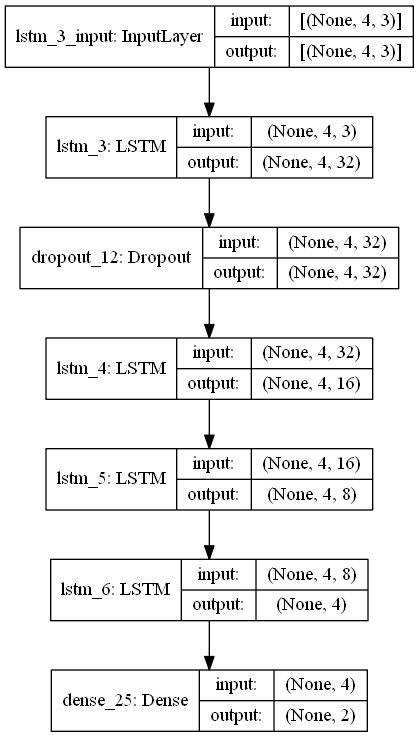

In [75]:
plot_model(model_lstm, show_shapes=True, show_layer_names=True)

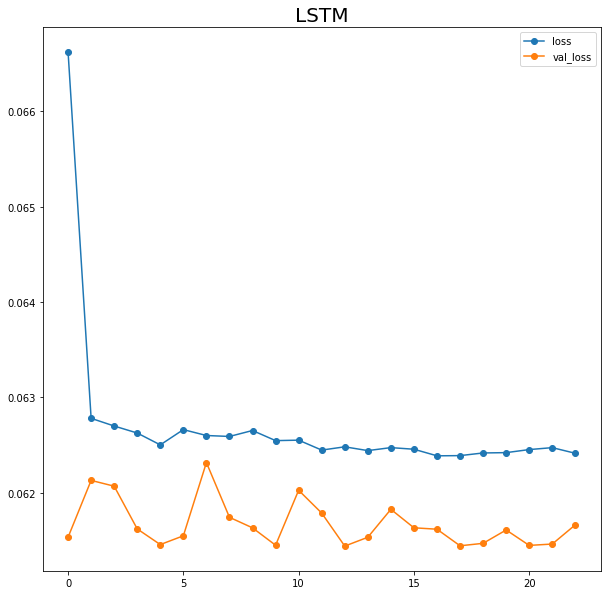

In [84]:
hist = history
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

ax.plot(hist.history["loss"], label = 'loss', marker='o')
ax.plot(hist.history["val_loss"], label = 'val_loss', marker='o')
ax.legend()

plt.title('LSTM', fontsize=20)
plt.show()

In [85]:
predict_X_Hats = model_lstm.predict(testX_lstm)

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x - testY_lstm*world_size_x), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  3.0823 미터


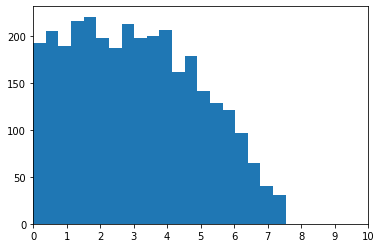

In [86]:
plt.hist(distance_gap, bins=20)
plt.xlim(0,10)
plt.xticks(range(0,11,1))
plt.show()

# CNN-LSTM

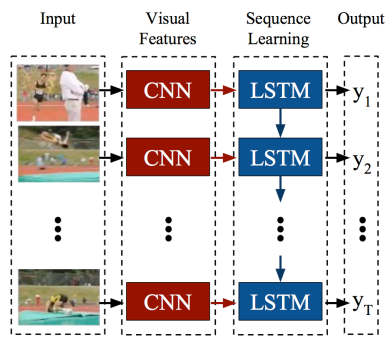

In [33]:
from IPython.display import Image

Image("lrcns-architecture.jpg")

In [34]:
lstm_time_series = 4

TDOA_images_ref_temp = np.array(TDOA_images_ref)

for i in range(lstm_time_series):
    globals()['TDOA_imgaes_lstm{}'.format(i)] = TDOA_images_ref_temp[i:int(MC_N-lstm_time_series+i+1)]

TDOA_images_lstm = np.stack(  [TDOA_imgaes_lstm0 , TDOA_imgaes_lstm1,TDOA_imgaes_lstm2,TDOA_imgaes_lstm3] ,axis=1 )
#TDOA_images_lstm = TDOA_images_lstm.swapaxes(2,4)

In [35]:
ylabels = np.array(ylabels)

for i in range(lstm_time_series):
    globals()['ylabels_lstm{}'.format(i)] = ylabels[i:int(MC_N-lstm_time_series+i+1)]

ylabels_lstm = np.stack(  [ylabels_lstm0, ylabels_lstm1, ylabels_lstm2, ylabels_lstm3] ,axis=1 )

ylabels_lstm = ylabels[lstm_time_series-1:]

In [36]:
TDOA_images_lstm.shape

(15997, 4, 3, 100, 100)

In [37]:
ylabels_lstm.shape

(15997, 2)

In [38]:
TDOA_images_test_lstm = TDOA_images_lstm[int(0.8*MC_N):]
TDOA_image_val_lstm = TDOA_images_lstm[int(0.6*MC_N):int(0.8*MC_N)]
TDOA_image_train_lstm = TDOA_images_lstm[:int(0.6*MC_N)]



ylabels_test_lstm = ylabels_lstm[int(0.8*MC_N):]
ylabels_val_lstm = ylabels_lstm[int(0.6*MC_N):int(0.8*MC_N)]
ylabels_train_lstm = ylabels_lstm[:int(0.6*MC_N)]

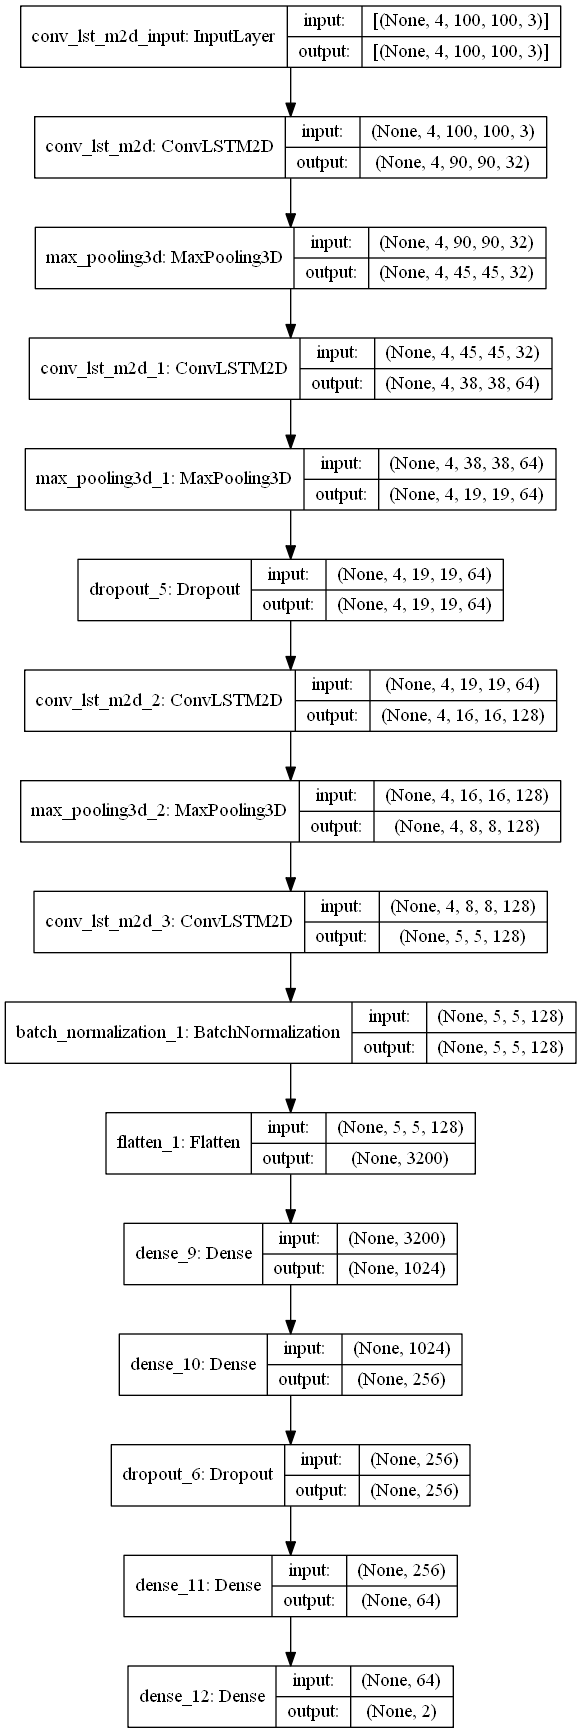

In [39]:
seq = keras.Sequential()
seq.add(layers.ConvLSTM2D(CNN1_outchannel, (CNN1_kernal, CNN1_kernal),
                        input_shape= (4, TDOA_sample_image.shape[0],TDOA_sample_image.shape[1], CNN1_inputchannel ) ,return_sequences=True))
seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides= (1,Pool_stride, Pool_stride), padding = "SAME"))
seq.add(layers.ConvLSTM2D(CNN2_outchannel, (CNN2_kernal, CNN2_kernal),return_sequences=True))
seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides=  (1,Pool_stride, Pool_stride), padding = "SAME"))
seq.add(layers.Dropout(0.4))
seq.add(layers.ConvLSTM2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal),return_sequences=True))
seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides=  (1,Pool_stride, Pool_stride), padding = "SAME"))
seq.add(layers.ConvLSTM2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal),return_sequences=False))
seq.add(layers.BatchNormalization()) 
seq.add(layers.Flatten())
seq.add(layers.Dense(1024, activation='relu'))
seq.add(layers.Dense(256, activation='relu'))
seq.add(layers.Dropout(0.4))
seq.add(layers.Dense(64, activation='relu'))
seq.add(layers.Dense(2, activation=None))

plot_model(seq, show_shapes=True, show_layer_names=True)

In [40]:
seq.compile(optimizer=Adam(learning_rate=1.0 * 1e-3),
        loss='mse',
        metrics=['mse'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', 
                              patience=15) 


history = seq.fit(TDOA_image_train_lstm.swapaxes(2,4), ylabels_train_lstm,
                    epochs=num_epochs, batch_size=batch_size,verbose=1,validation_data=(TDOA_image_val_lstm.swapaxes(2,4), ylabels_val_lstm),
                     callbacks= [ earlystopping])

print('Finished Training')

Epoch 1/50
640/640 [==============================] - 582s 901ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 2/50
640/640 [==============================] - 569s 889ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 3/50
640/640 [==============================] - 549s 857ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 4/50
640/640 [==============================] - 541s 845ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 5/50
640/640 [==============================] - 540s 843ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 6/50
640/640 [==============================] - 540s 844ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 7/50
640/640 [==============================] - 540s 843ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 8/50
640/640 [============================

[Text(0.5, 1.0, 'loss')]

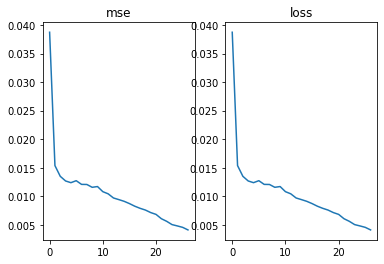

In [41]:
hist = history
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

ax.plot(hist.history["loss"], label = 'loss', marker='o')
ax.plot(hist.history["val_loss"], label = 'val_loss', marker='o')
ax.legend()

plt.title('Conv-lstm / Adam', fontsize=20)
plt.show()

In [43]:
predict_X_Hats = seq.predict(TDOA_images_test_lstm.swapaxes(2,4))

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x -ylabels_test_lstm*world_size_x), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  1.3766 미터


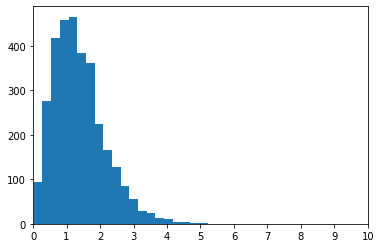

In [44]:
plt.hist(distance_gap, bins=20)
plt.xlim(0,10)
plt.xticks(range(0,11,1))
plt.show()

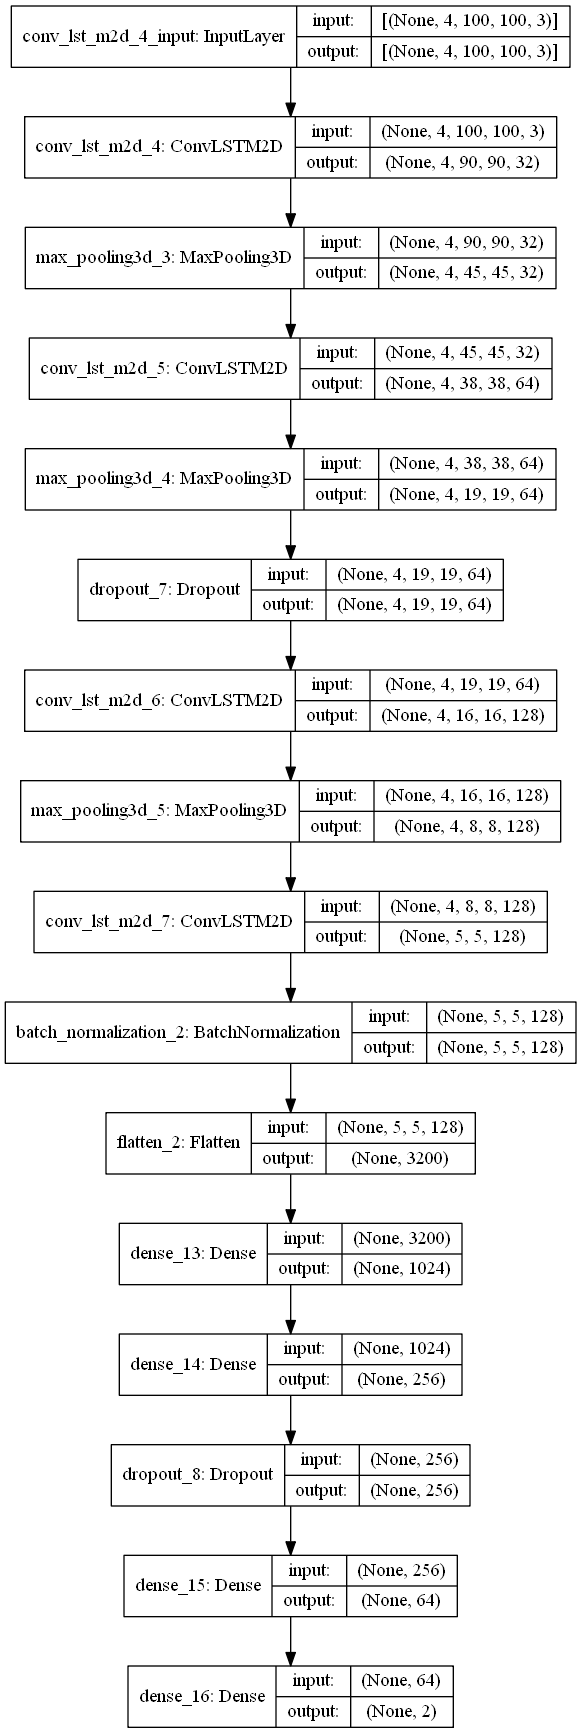

In [45]:
seq = keras.Sequential()
seq.add(layers.ConvLSTM2D(CNN1_outchannel, (CNN1_kernal, CNN1_kernal),
                        input_shape= (4, TDOA_sample_image.shape[0],TDOA_sample_image.shape[1], CNN1_inputchannel ) ,return_sequences=True))
seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides= (1,Pool_stride, Pool_stride), padding = "SAME"))
seq.add(layers.ConvLSTM2D(CNN2_outchannel, (CNN2_kernal, CNN2_kernal),return_sequences=True))
seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides=  (1,Pool_stride, Pool_stride), padding = "SAME"))
seq.add(layers.Dropout(0.4))
seq.add(layers.ConvLSTM2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal),return_sequences=True))
seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides=  (1,Pool_stride, Pool_stride), padding = "SAME"))
seq.add(layers.ConvLSTM2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal),return_sequences=False))
seq.add(layers.BatchNormalization()) 
seq.add(layers.Flatten())
seq.add(layers.Dense(1024, activation='relu'))
seq.add(layers.Dense(256, activation='relu'))
seq.add(layers.Dropout(0.4))
seq.add(layers.Dense(64, activation='relu'))
seq.add(layers.Dense(2, activation=None))

plot_model(seq, show_shapes=True, show_layer_names=True)

In [46]:
seq.compile(optimizer=DiffGrad(),
        loss='mse',
        metrics=['mse'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', 
                              patience=15) 


history = seq.fit(TDOA_image_train_lstm.swapaxes(2,4), ylabels_train_lstm,
                    epochs=num_epochs, batch_size=batch_size,verbose=1,validation_data=(TDOA_image_val_lstm.swapaxes(2,4), ylabels_val_lstm),
                     callbacks= [ earlystopping])

print('Finished Training')

Epoch 1/50
640/640 [==============================] - 582s 903ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 2/50
640/640 [==============================] - 545s 852ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 3/50
640/640 [==============================] - 547s 855ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 4/50
640/640 [==============================] - 547s 855ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 5/50
640/640 [==============================] - 547s 855ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 6/50
640/640 [==============================] - 548s 856ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 7/50
640/640 [==============================] - 548s 856ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 8/50
640/640 [============================

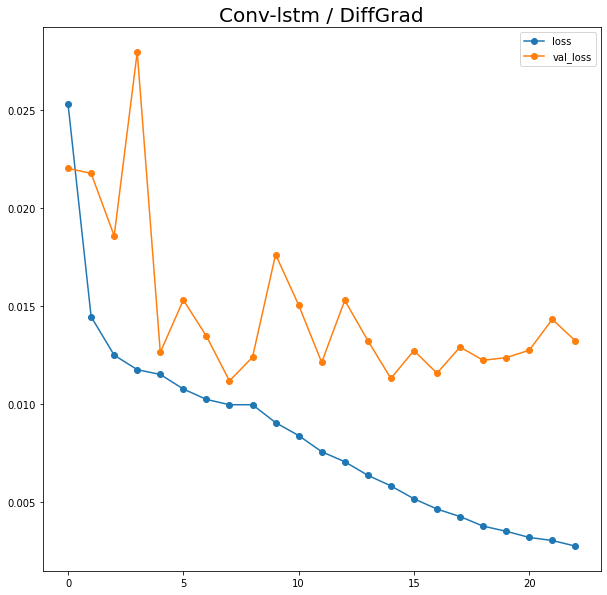

In [52]:
hist = history
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

ax.plot(hist.history["loss"], label = 'loss', marker='o')
ax.plot(hist.history["val_loss"], label = 'val_loss', marker='o')
ax.legend()

plt.title('Conv-lstm / DiffGrad', fontsize=20)
plt.show()

In [49]:
predict_X_Hats = seq.predict(TDOA_images_test_lstm.swapaxes(2,4))

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x -ylabels_test_lstm*world_size_x), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  1.3916 미터


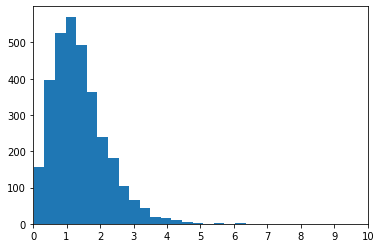

In [50]:
plt.hist(distance_gap, bins=20)
plt.xlim(0,10)
plt.xticks(range(0,11,1))
plt.show()